In [1]:
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [2]:
raw = mne.io.read_raw_edf('../BVAnalyzer/export/sub-rtbpd003_ses-nf2_task_feedback_run-01_cleaned.edf', preload=True)
raw

Extracting EDF parameters from /Users/cccbauer/Documents/GitHub/rt-BPD/analysis/BVAnalyzer/export/sub-rtbpd003_ses-nf2_task_feedback_run-01_cleaned.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 44999  =      0.000 ...   179.996 secs...


<RawEDF | sub-rtbpd003_ses-nf2_task_feedback_run-01_cleaned.edf, 32 x 45000 (180.0 s), ~11.0 MiB, data loaded>

In [3]:
pda = pd.read_csv('../murfi/sub-rtBPD003_ses-nf_task-feedback_run-01_PDA.csv')
pda_signal = pda.iloc[:, 0].values  # adjust based on column structure
pda_signal

array([ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      , -0.020739,  0.289791,  0.022934,  0.175495,
        0.124757,  0.175281,  0.106063,  0.014794,  0.11553 ,  0.227791,
        0.142647,  0.03228 ,  0.032175,  0.008961, -0.001549, -0.086719,
       -0.198549, -0.034456,  0.004653,  0.031492,  0.275361,  0.194273,
        0.240349,  0.141674,  0.108914,  0.000638,  0.120705,  0.11529 ,
        0.060699,  0.022516,  0.058842,  0.122358, -0.041444, -0.006015,
       -0.019878,  0.021121,  0.014684,  0.044464,  0.048689,  0.047782,
        0.10379 ,  0.101758,  0.037175,  0.069467,  0.095984,  0.168834,
        0.115294,  0.178553,  0.044025,  0.081509,  0.077418,  0.141709,
        0.11388 ,  0.093542,  0.034966, -0.044102, -0.062494, -0.077436,
        0.094607,  0.197714,  0.172179,  0.179277,  0.170454,  0.047362,
        0.058982,  0.018535,  0.078351,  0.023586, -0.091607, -0.182139,
       -0.312861, -0.294898, -0.049351,  0.198593, 

## Step 1: PDA Upsampling to 4 Hz

In [4]:
from scipy.interpolate import interp1d

# Original PDA: every 1.2 seconds
original_fs = 1 / 1.2  # ~0.833 Hz
pda_time_orig = np.arange(len(pda_signal)) / original_fs

# Target time: 4 Hz over full EEG duration
target_fs = 4.0
duration_sec = raw.times[-1]
target_time = np.arange(0, duration_sec, 1/target_fs)

# Interpolate PDA to 4 Hz
interp_func = interp1d(pda_time_orig, pda_signal, kind='cubic', fill_value='extrapolate')
pda_resampled = interp_func(target_time)

# Normalize
pda_resampled_z = (pda_resampled - np.mean(pda_resampled)) / np.std(pda_resampled)


## Step 2: EEG time-frequency decomposition (via Stockwell or STFT) and Downsample EEG Power to 4‚ÄØHz


In [5]:
from scipy.signal import stft

# Parameters
fs = raw.info['sfreq']  # 250 Hz
window_sec = 1.0
nperseg = int(window_sec * fs)
noverlap = nperseg - int(fs / 4)  # Step size = 250/4 = 62.5 samples ‚Üí ~4 Hz output

# Extract EEG data
picks_eeg = mne.pick_types(raw.info, eeg=True)

eeg_data = raw.get_data(picks='eeg')  # shape: (n_channels, n_samples)

# STFT across all channels
f, t, Zxx = stft(eeg_data, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1)

# Zxx: shape (n_channels, n_freqs, n_windows)
power = np.abs(Zxx) ** 2
power = power.transpose(2, 0, 1)  # reshape to (n_windows, n_channels, n_freqs)

# Save frequency bins to use later
freqs = f  # <--- this is what was missing


## Step 4: Divide Spectrum into 10 Energy-Uniform Frequency Bands


Step 4.1: Compute total energy per frequency bin

In [6]:
# power: shape (n_windows, n_channels, n_freqs)
n_windows, n_channels, n_freqs = power.shape

# Sum across time and channels to get total energy per freq bin
total_energy_per_freq = power.sum(axis=(0, 1))  # shape: (n_freqs,)


‚úÖ Step 4.2: Define 10 energy-equal frequency bands


In [7]:
# Compute cumulative energy
cumulative_energy = np.cumsum(total_energy_per_freq)
total_energy = cumulative_energy[-1]
energy_bins = np.linspace(0, total_energy, 11)

# Find frequency indices that split energy into 10 equal parts
band_edges = np.searchsorted(cumulative_energy, energy_bins)
band_edges = np.unique(band_edges)


‚úÖ Step 4.3: Average power within each band


In [8]:
# Create new array: (n_windows, n_channels, 10 bands)
n_bands = 10
power_banded = np.zeros((n_windows, n_channels, n_bands))

for i in range(n_bands):
    f_start = band_edges[i]
    f_end = band_edges[i+1] if i+1 < len(band_edges) else n_freqs
    power_banded[:, :, i] = power[:, :, f_start:f_end].mean(axis=2)


## Step 5: Normalize Each Frequency Band (Per Channel)


In [9]:
# power_banded: shape (n_samples, n_channels, 10 bands)
n_samples, n_channels, n_bands = power_banded.shape

# Reshape to 2D: (n_samples, n_channels * n_bands)
X_raw = power_banded.reshape(n_samples, n_channels * n_bands)

# Normalize across time for each feature
X_mean = X_raw.mean(axis=0)
X_std = X_raw.std(axis=0)
X_norm = (X_raw - X_mean) / X_std


## Step 6: Align EEG Features and PDA Targets


In [10]:
# Truncate to minimum length
min_len = min(len(pda_resampled_z), X_norm.shape[0])
X_aligned = X_norm[:min_len]
y_aligned = pda_resampled_z[:min_len]

print(f"EEG features shape: {X_aligned.shape}")
print(f"PDA shape: {y_aligned.shape}")


EEG features shape: (720, 320)
PDA shape: (720,)


## Step 7: Train Ridge Regression Model


In [11]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

# Fit model
ridge = RidgeCV(alphas=np.logspace(-3, 3, 20), cv=5)
ridge.fit(X_aligned, y_aligned)

# Report
r2 = ridge.score(X_aligned, y_aligned)
print(f"‚úÖ Ridge Regression R¬≤ score: {r2:.3f}")


‚úÖ Ridge Regression R¬≤ score: 0.227


## 1. Visualize Actual vs. Predicted PDA



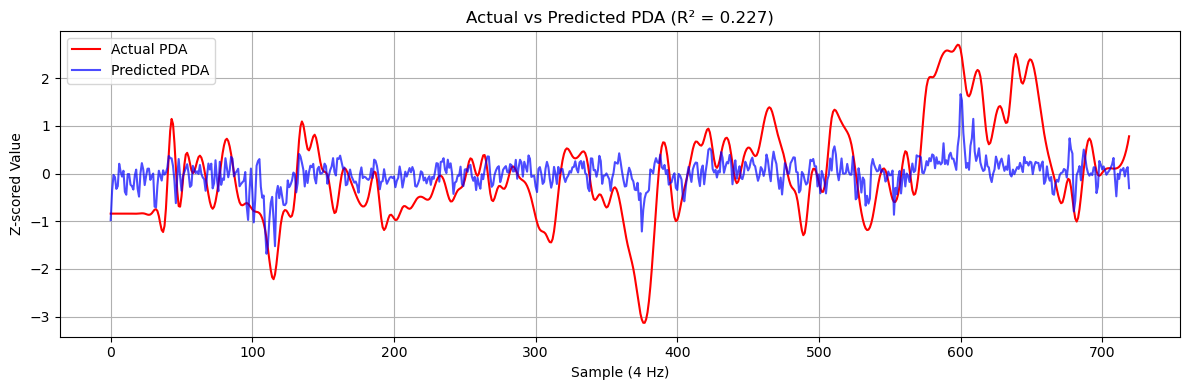

In [12]:
y_pred = ridge.predict(X_aligned)

plt.figure(figsize=(12, 4))
plt.plot(y_aligned, label='Actual PDA', color='red')
plt.plot(y_pred, label='Predicted PDA', color='blue', alpha=0.7)
plt.title(f'Actual vs Predicted PDA (R¬≤ = {r2:.3f})')
plt.xlabel('Sample (4 Hz)')
plt.ylabel('Z-scored Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2. Inspect Model Coefficients

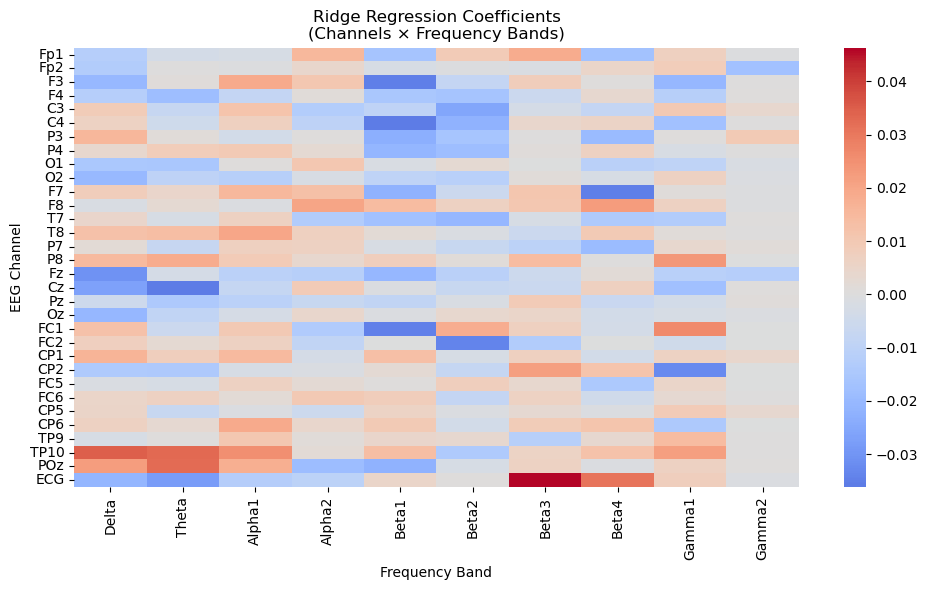

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define band labels
band_labels = [
    "Delta", "Theta", "Alpha1", "Alpha2",
    "Beta1", "Beta2", "Beta3", "Beta4",
    "Gamma1", "Gamma2"
]

# Reshape coefficients to (channels, bands)
coefs = ridge.coef_.reshape(n_channels, n_bands)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(coefs, xticklabels=band_labels,
            yticklabels=raw.ch_names[:n_channels],
            cmap='coolwarm', center=0)

plt.title('Ridge Regression Coefficients\n(Channels √ó Frequency Bands)')
plt.xlabel('Frequency Band')
plt.ylabel('EEG Channel')
plt.tight_layout()
plt.show()


## Top Contributing Channels and Frequencies


1. Reshape and Rank Absolute Coefficients

In [69]:
# Reshape back to (channels, 10 bands)
coefs = ridge.coef_.reshape(n_channels, n_bands)

# Compute absolute weight for ranking
abs_coefs = np.abs(coefs)

# Rank all channel √ó band pairs by contribution
flat_indices = np.argsort(abs_coefs.ravel())[::-1]
ranked = [(raw.ch_names[i // n_bands], f'Band {i % n_bands + 1}', coefs[i // n_bands, i % n_bands])
          for i in flat_indices]
# EEG band labels (assuming bands were defined roughly in this order)
band_labels = [
    "Delta", "Theta", "Alpha1", "Alpha2",
    "Beta1", "Beta2", "Beta3", "Beta4",
    "Gamma1", "Gamma2"
]

# Reshape back to (channels, 10 bands)
coefs = ridge.coef_.reshape(n_channels, n_bands)

# Compute absolute weight for ranking
abs_coefs = np.abs(coefs)

# Rank all channel √ó band pairs by contribution
flat_indices = np.argsort(abs_coefs.ravel())[::-1]
ranked = [(raw.ch_names[i // n_bands], band_labels[i % n_bands], coefs[i // n_bands, i % n_bands])
          for i in flat_indices]


2. Display Top 10 Contributors

In [70]:
print("üîù Top 10 contributing channel √ó frequency band pairs:")
for i, (ch, band, weight) in enumerate(ranked[:10], 1):
    print(f"{i}. {ch} ‚Äî {band} ‚Üí Coefficient = {weight:.4f}")


üîù Top 10 contributing channel √ó frequency band pairs:
1. ECG ‚Äî Beta3 ‚Üí Coefficient = 0.0463
2. Cz ‚Äî Theta ‚Üí Coefficient = -0.0362
3. C4 ‚Äî Beta1 ‚Üí Coefficient = -0.0358
4. F3 ‚Äî Beta1 ‚Üí Coefficient = -0.0352
5. F7 ‚Äî Beta4 ‚Üí Coefficient = -0.0351
6. FC1 ‚Äî Beta1 ‚Üí Coefficient = -0.0348
7. TP10 ‚Äî Delta ‚Üí Coefficient = 0.0348
8. FC2 ‚Äî Beta2 ‚Üí Coefficient = -0.0339
9. TP10 ‚Äî Theta ‚Üí Coefficient = 0.0331
10. POz ‚Äî Theta ‚Üí Coefficient = 0.0327


3. Optional: Grouped Summaries
‚ñ∂Ô∏è Top Channels (aggregated over bands)

In [71]:
channel_scores = abs_coefs.sum(axis=1)
top_channels = np.argsort(channel_scores)[::-1]

print("\nüéØ Top 5 contributing EEG channels (sum across bands):")
for i in range(5):
    ch = raw.ch_names[top_channels[i]]
    score = channel_scores[top_channels[i]]
    print(f"{i+1}. {ch} ‚Üí Total |weight| = {score:.4f}")



üéØ Top 5 contributing EEG channels (sum across bands):
1. ECG ‚Üí Total |weight| = 0.1634
2. TP10 ‚Üí Total |weight| = 0.1628
3. FC1 ‚Üí Total |weight| = 0.1320
4. POz ‚Üí Total |weight| = 0.1305
5. F3 ‚Üí Total |weight| = 0.1230


 Top Frequency Bands (aggregated over channels)

In [72]:
# Sum of absolute weights per frequency band across all channels
band_scores = abs_coefs.sum(axis=0)
top_bands = np.argsort(band_scores)[::-1]

print("\nüéØ Top 5 contributing frequency bands (sum across channels):")
for i in range(5):
    band_name = band_labels[top_bands[i]]
    score = band_scores[top_bands[i]]
    print(f"{i+1}. {band_name} ‚Üí Total |weight| = {score:.4f}")


üéØ Top 5 contributing frequency bands (sum across channels):
1. Delta ‚Üí Total |weight| = 0.4029
2. Beta1 ‚Üí Total |weight| = 0.3872
3. Gamma1 ‚Üí Total |weight| = 0.3309
4. Theta ‚Üí Total |weight| = 0.3261
5. Beta2 ‚Üí Total |weight| = 0.2984


Topomap of Ridge Coefficients for One Band

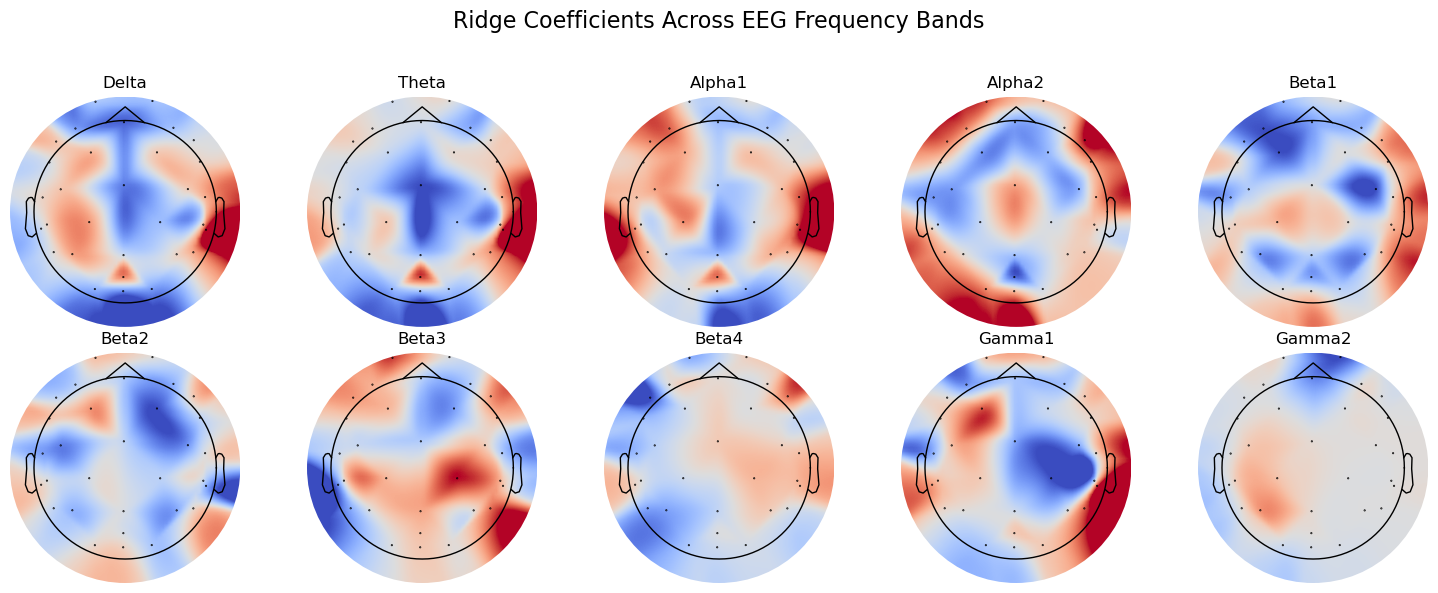

In [73]:
from mne.viz import plot_topomap
import matplotlib.pyplot as plt
import numpy as np

# Make sure montage and coefs are valid
montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage, on_missing='ignore')
picks_eeg = mne.pick_types(raw.info, eeg=True)

# Get channel positions and filter valid ones
valid_pos = []
valid_idx = []
for i in picks_eeg:
    pos_2d = raw.info['chs'][i]['loc'][:2]
    if not np.any(np.isnan(pos_2d)):
        valid_pos.append(pos_2d)
        valid_idx.append(i)

valid_pos = np.array(valid_pos)
coefs_valid = coefs[valid_idx, :]

# Band labels
band_labels = [
    "Delta", "Theta", "Alpha1", "Alpha2",
    "Beta1", "Beta2", "Beta3", "Beta4",
    "Gamma1", "Gamma2"
]

# Grid plot of all bands
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

for i in range(len(band_labels)):
    ax = axs[i]
    weights = coefs_valid[:, i]
    plot_topomap(weights, valid_pos, axes=ax, show=False, contours=0, cmap="coolwarm")
    ax.set_title(band_labels[i])

fig.suptitle("Ridge Coefficients Across EEG Frequency Bands", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [74]:
# Print frequency ranges for each of the 10 bands
print("üéº Frequency Ranges of EEG Bands:")
for i in range(len(band_edges) - 1):
    f_start = freqs[band_edges[i]]
    f_end = freqs[band_edges[i+1] - 1] if band_edges[i+1] < len(freqs) else freqs[-1]
    print(f"{band_labels[i]}: {f_start:.1f}‚Äì{f_end:.1f} Hz")


üéº Frequency Ranges of EEG Bands:
Delta: 0.0‚Äì0.0 Hz
Theta: 1.0‚Äì1.0 Hz
Alpha1: 2.0‚Äì3.0 Hz
Alpha2: 4.0‚Äì6.0 Hz
Beta1: 7.0‚Äì10.0 Hz
Beta2: 11.0‚Äì12.0 Hz
Beta3: 13.0‚Äì13.0 Hz
Beta4: 14.0‚Äì15.0 Hz
Gamma1: 16.0‚Äì124.0 Hz


## Delay Embedding for EEG Features


## Nested Cross-Validation Setup



‚úÖ Nested CV Summary:
Mean R¬≤:        -5.667
Mean NMSE:      6.667
Mean Pearson r: 0.030
Best Œª per fold: [0.004641588833612777, 2.154434690031882, 0.004641588833612777, 0.021544346900318832, 0.004641588833612777, 10.0, 0.021544346900318832, 0.021544346900318832, 2.154434690031882, 2.154434690031882]
Mean log‚ÇÅ‚ÇÄ(Œª):   -1.00


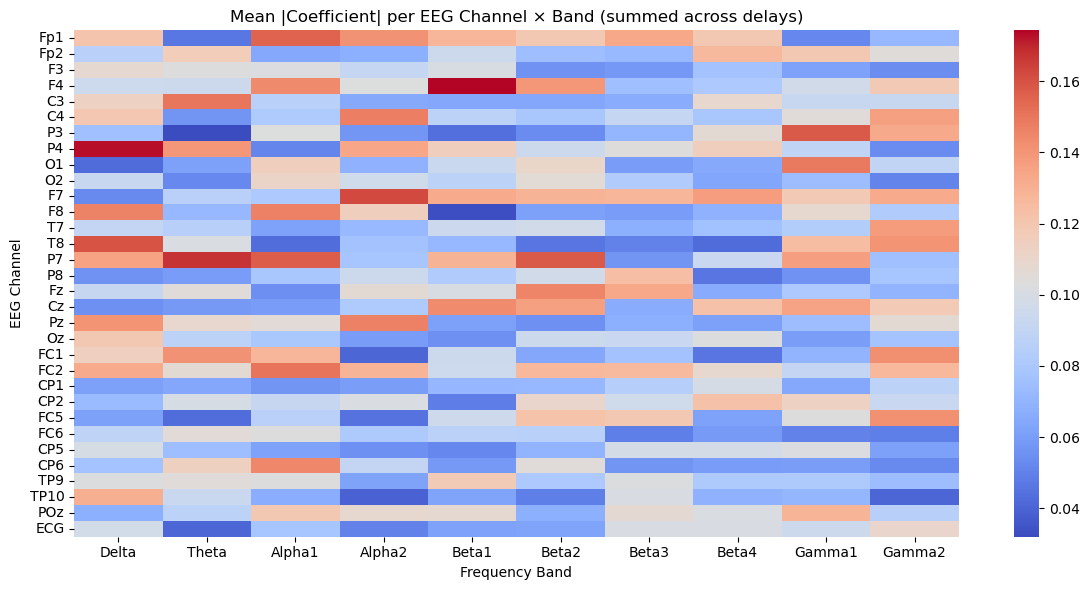

In [75]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
m, k = 2, 5      # outer loop: 2√ó5 = 10 folds
n = 30           # inner loop: 30 random splits for lambda search
lambdas = np.logspace(-3, 3, 10)

# Storage for outer loop
outer_r2_scores = []
outer_nmse_scores = []
outer_corr_scores = []
best_lambdas = []
all_coefs = []

# Outer cross-validation: m√ók = 10 folds with time-blocked sampling
block_size = len(y_with_delays) // (m * k)
block_indices = [np.arange(i * block_size, (i + 1) * block_size) for i in range(m * k)]

for outer_idx in range(m * k):
    test_idx = block_indices[outer_idx]
    train_idx = np.hstack([block_indices[i] for i in range(m * k) if i != outer_idx])

    X_train, X_test = X_with_delays[train_idx], X_with_delays[test_idx]
    y_train, y_test = y_with_delays[train_idx], y_with_delays[test_idx]

    # Inner CV for best lambda selection
    best_lambda = None
    best_nmse = np.inf

    for lam in lambdas:
        nmse_list = []
        for _ in range(n):
            X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.2)
            model = Ridge(alpha=lam)
            model.fit(X_subtrain, y_subtrain)
            y_pred = model.predict(X_val)

            mse = mean_squared_error(y_val, y_pred)
            var = np.var(y_val)
            nmse = mse / var
            nmse_list.append(nmse)

        mean_nmse = np.mean(nmse_list)
        if mean_nmse < best_nmse:
            best_nmse = mean_nmse
            best_lambda = lam

    best_lambdas.append(best_lambda)

    # Train on full train set with best lambda
    final_model = Ridge(alpha=best_lambda)
    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_test)

    # Store results
    outer_r2_scores.append(r2_score(y_test, y_pred))
    outer_nmse_scores.append(mean_squared_error(y_test, y_pred) / np.var(y_test))
    outer_corr_scores.append(pearsonr(y_test, y_pred)[0])
    all_coefs.append(final_model.coef_)

# ===== Results Summary =====
print("\n‚úÖ Nested CV Summary:")
print(f"Mean R¬≤:        {np.mean(outer_r2_scores):.3f}")
print(f"Mean NMSE:      {np.mean(outer_nmse_scores):.3f}")
print(f"Mean Pearson r: {np.mean(outer_corr_scores):.3f}")
print(f"Best Œª per fold: {best_lambdas}")
print(f"Mean log‚ÇÅ‚ÇÄ(Œª):   {np.mean(np.log10(best_lambdas)):.2f}")

# ===== Coefficient Summary (per EEG channel √ó band) =====

# Assuming you used delay embedding: (channels √ó bands √ó delays)
n_features = X_with_delays.shape[1]
n_channels = 32           # update if needed
n_bands = 10
n_delays = n_features // (n_channels * n_bands)

# Mean coefficients across folds
all_coefs = np.array(all_coefs)  # shape: (folds, n_features)
mean_coefs = all_coefs.mean(axis=0)

# Reshape to 3D: (channels, bands, delays)
coefs_3d = mean_coefs.reshape(n_channels, n_bands, n_delays)

# Collapse across delays ‚Üí get total contribution per channel √ó band
coefs_sum = np.abs(coefs_3d).sum(axis=2)  # shape: (channels, bands)

# Plot heatmap
band_labels = ["Delta", "Theta", "Alpha1", "Alpha2", "Beta1",
               "Beta2", "Beta3", "Beta4", "Gamma1", "Gamma2"]

plt.figure(figsize=(12, 6))
sns.heatmap(coefs_sum, xticklabels=band_labels, yticklabels=raw.ch_names[:n_channels], cmap="coolwarm")
plt.title("Mean |Coefficient| per EEG Channel √ó Band (summed across delays)")
plt.xlabel("Frequency Band")
plt.ylabel("EEG Channel")
plt.tight_layout()
plt.show()


## FDR Correction (Benjamini‚ÄìHochberg)


‚úÖ FDR Correction completed ‚Äî 2011 significant weights (of 2880)
Example corrected p-value range: min=0.00000, max=0.99553


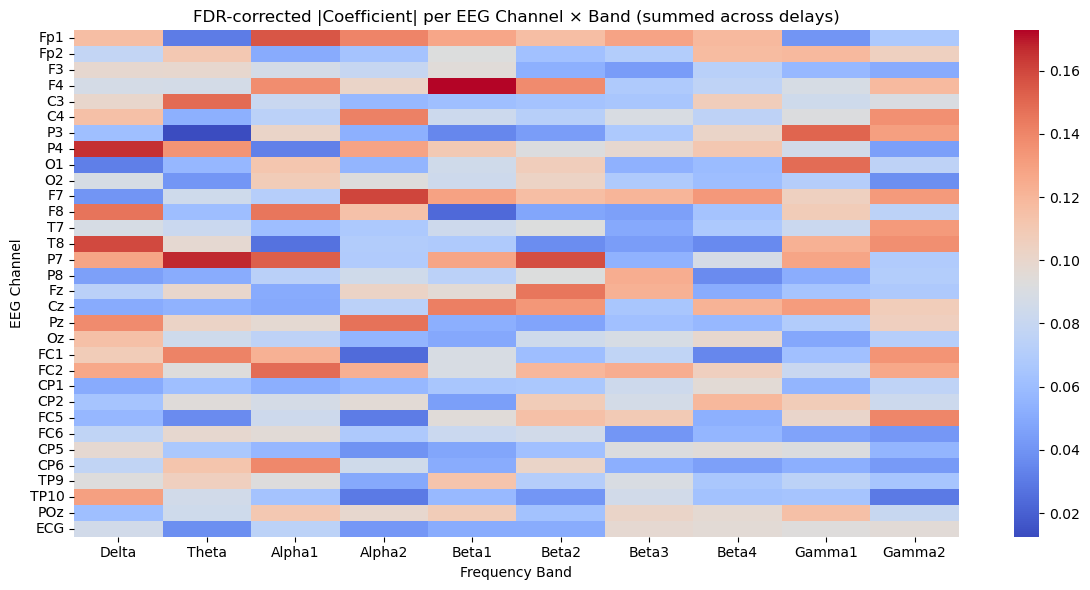

In [76]:
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ttest_1samp

# --- FDR Correction on Ridge Coefficients ---

# Step 1: t-test across folds to get p-values
t_vals, p_vals = ttest_1samp(all_coefs, popmean=0, axis=0)  # shape: (n_features,)

# Step 2: FDR correction
significant_mask, pvals_corrected = fdrcorrection(p_vals, alpha=0.05)

print(f"\n‚úÖ FDR Correction completed ‚Äî {np.sum(significant_mask)} significant weights (of {len(p_vals)})")
print(f"Example corrected p-value range: min={pvals_corrected.min():.5f}, max={pvals_corrected.max():.5f}")

# Step 3: Zero out non-significant coefficients
mean_coefs_fdr = mean_coefs.copy()
mean_coefs_fdr[~significant_mask] = 0

# Step 4: Visualize only significant weights (channel √ó band)
coefs_3d_fdr = mean_coefs_fdr.reshape(n_channels, n_bands, n_delays)
coefs_sum_fdr = np.abs(coefs_3d_fdr).sum(axis=2)

plt.figure(figsize=(12, 6))
sns.heatmap(coefs_sum_fdr, xticklabels=band_labels, yticklabels=raw.ch_names[:n_channels], cmap="coolwarm")
plt.title("FDR-corrected |Coefficient| per EEG Channel √ó Band (summed across delays)")
plt.xlabel("Frequency Band")
plt.ylabel("EEG Channel")
plt.tight_layout()
plt.show()


## Top 5 Most Significant EEG Features

In [77]:
# Reconstruct channel √ó band √ó delay labels
feature_labels = []
for ch in range(n_channels):
    for b in range(n_bands):
        for d in range(n_delays):
            feature_labels.append((raw.ch_names[ch], band_labels[b], delays[d]))

# Extract p-values and coefficients
significant_features = [(feature_labels[i], mean_coefs[i], pvals_corrected[i])
                        for i in range(len(pvals_corrected)) if significant_mask[i]]

# Sort by absolute weight
top_features = sorted(significant_features, key=lambda x: abs(x[1]), reverse=True)[:5]

# Display
print("üîù Top 5 Significant EEG Fingerprint Features (after FDR correction):")
for (ch, band, delay), weight, pval in top_features:
    print(f"  ‚Ä¢ {ch} ‚Äì {band} ‚Äì {delay/fs:.2f}s delay ‚Üí weight = {weight:.4f}, p = {pval:.5f}")


üîù Top 5 Significant EEG Fingerprint Features (after FDR correction):
  ‚Ä¢ F4 ‚Äì Alpha1 ‚Äì 0.03s delay ‚Üí weight = -0.0506, p = 0.00001
  ‚Ä¢ C4 ‚Äì Alpha2 ‚Äì 0.00s delay ‚Üí weight = 0.0448, p = 0.00001
  ‚Ä¢ P4 ‚Äì Delta ‚Äì 0.01s delay ‚Üí weight = -0.0447, p = 0.00000
  ‚Ä¢ O1 ‚Äì Gamma1 ‚Äì 0.02s delay ‚Üí weight = 0.0438, p = 0.00001
  ‚Ä¢ FC1 ‚Äì Beta1 ‚Äì 0.01s delay ‚Üí weight = -0.0420, p = 0.00001


## Grid of FDR-Corrected Topomaps Across DelaysPlot Topomaps for Specific Delays

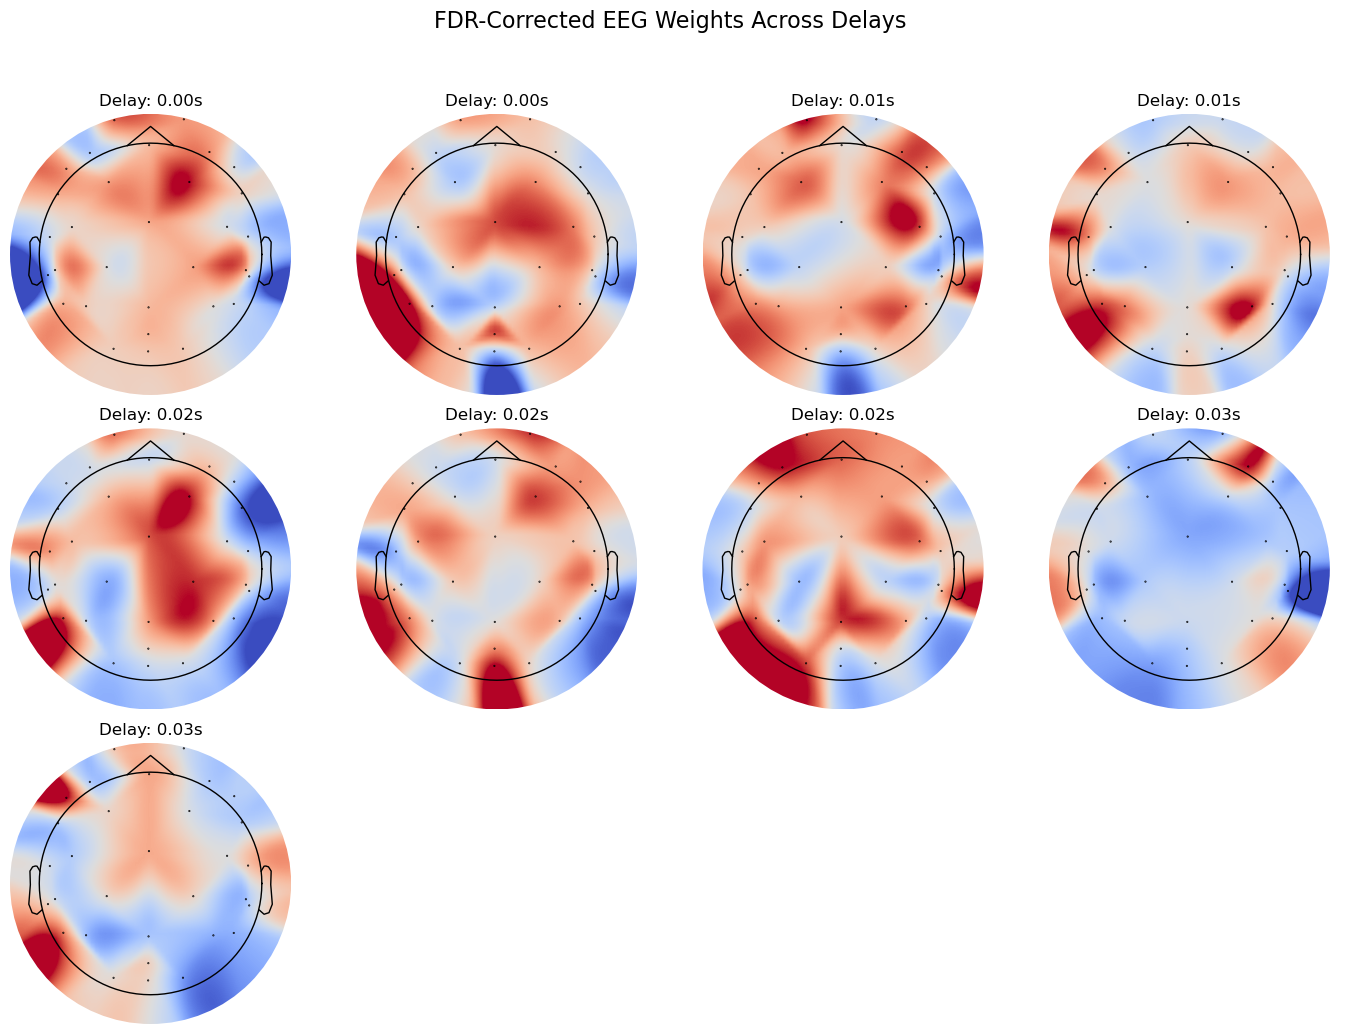

In [78]:
# Delay setup (make sure `delays` and fs are defined)
delay_times = [d / fs for d in range(n_delays)]  # in seconds

# Prepare valid EEG channel positions
valid_idx = []
valid_pos = []
for i in range(n_channels):
    loc = raw.info['chs'][i]['loc'][:2]
    if not np.any(np.isnan(loc)):
        valid_idx.append(i)
        valid_pos.append(loc)
valid_pos = np.array(valid_pos)

# Create grid layout
n_cols = 4
n_rows = int(np.ceil(n_delays / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3.5 * n_rows))

for i, ax in enumerate(axs.flat):
    if i < n_delays:
        # Get FDR-corrected weights for this delay (sum across bands)
        delay_weights = np.abs(coefs_3d_fdr[:, :, i]).sum(axis=1)

        # Filter valid channels
        weights_valid = [delay_weights[j] for j in valid_idx]

        plot_topomap(weights_valid, valid_pos, axes=ax, contours=0, cmap="coolwarm", show=False)
        ax.set_title(f"Delay: {delay_times[i]:.2f}s")
    else:
        ax.axis("off")

fig.suptitle("FDR-Corrected EEG Weights Across Delays", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Matplotlib Animation Across Delays



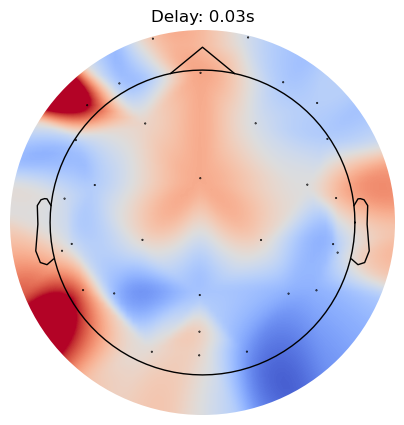

In [79]:
import matplotlib.pyplot as plt
from mne.viz import plot_topomap
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Prepare topomap data
topomap_series = []
for i in range(n_delays):
    weights = np.abs(coefs_3d_fdr[:, :, i]).sum(axis=1)
    topomap_series.append([weights[j] for j in valid_idx])

# Setup figure
fig, ax = plt.subplots(figsize=(5, 5))

def update(frame):
    ax.clear()
    im, _ = plot_topomap(topomap_series[frame], valid_pos, axes=ax,
                         contours=0, cmap="coolwarm", show=False)
    ax.set_title(f"Delay: {delay_times[frame]:.2f}s")
    return [im]

ani = FuncAnimation(fig, update, frames=n_delays, interval=800, blit=True)

plt.rcParams["animation.html"] = "jshtml"
HTML(ani.to_jshtml())  # ‚úÖ only this renders in notebook


‚úÖ Most predictive feature: F4 ‚Äî Beta1


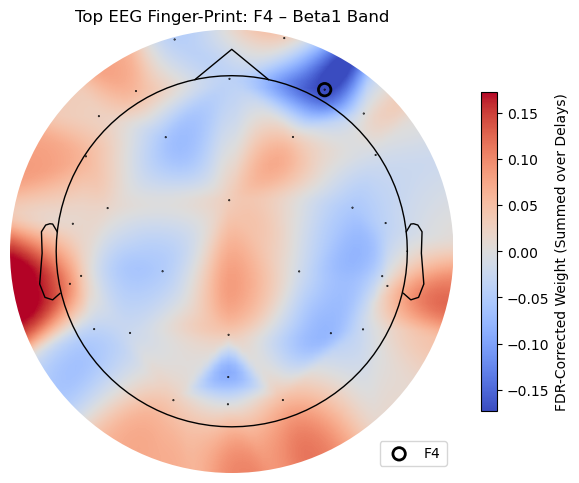

In [80]:
from mne.viz import plot_topomap
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Identify top electrode √ó band
coefs_3d_fdr = mean_coefs_fdr.reshape(n_channels, n_bands, n_delays)
contrib_map = np.abs(coefs_3d_fdr).sum(axis=2)
top_ch_idx, top_band_idx = np.unravel_index(np.argmax(contrib_map), contrib_map.shape)
top_band_name = band_labels[top_band_idx]
top_ch_name = raw.ch_names[top_ch_idx]

print(f"‚úÖ Most predictive feature: {top_ch_name} ‚Äî {top_band_name}")

# Step 2: Prepare weights and positions
weights = coefs_3d_fdr[:, top_band_idx, :].sum(axis=1)
valid_idx = []
valid_pos = []
valid_weights = []
for i in range(n_channels):
    pos = raw.info['chs'][i]['loc'][:2]
    if not np.any(np.isnan(pos)):
        valid_idx.append(i)
        valid_pos.append(pos)
        valid_weights.append(weights[i])

valid_pos = np.array(valid_pos)

# Get position of top electrode
top_plot_idx = valid_idx.index(top_ch_idx)
top_plot_pos = valid_pos[top_plot_idx]

# Step 3: Plot with circle on top electrode
fig, ax = plt.subplots(figsize=(6, 5))
im, _ = plot_topomap(valid_weights, valid_pos, axes=ax, cmap="coolwarm", contours=0, show=False)
ax.scatter(*top_plot_pos, color='black', s=80, facecolors='none', linewidths=2, label=f'{top_ch_name}')
plt.colorbar(im, ax=ax, shrink=0.7, label='FDR-Corrected Weight (Summed over Delays)')
ax.set_title(f"Top EEG Finger-Print: {top_ch_name} ‚Äì {top_band_name} Band")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


## Smoothed + Normalized PDA vs. EEG (Top Feature)

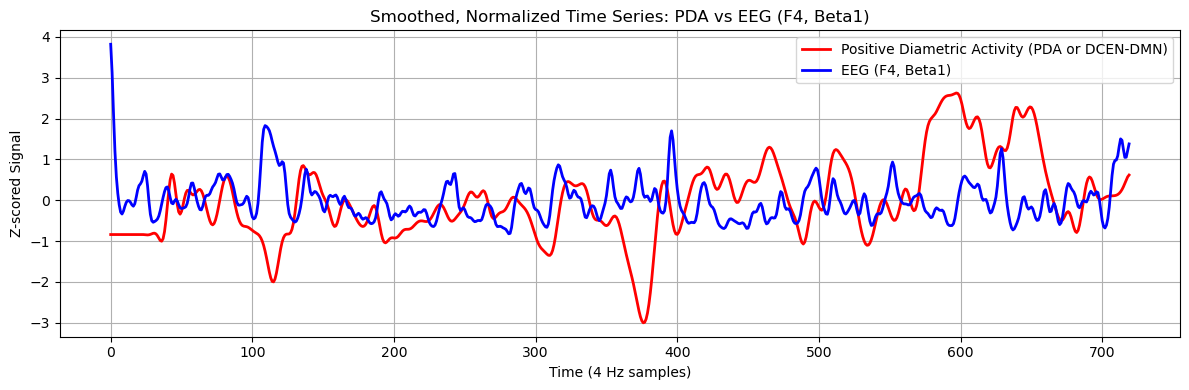

In [81]:
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# Step 1: Extract EEG time series for top electrode √ó band across all delays
eeg_feature_idx = top_ch_idx * n_bands * n_delays + top_band_idx * n_delays
eeg_time_series = X_with_delays[:, eeg_feature_idx:eeg_feature_idx + n_delays].sum(axis=1)

# Step 2: Normalize (z-score)
eeg_z = zscore(eeg_time_series)
pda_z = zscore(y_with_delays)

# Step 3: Smooth both with a Gaussian filter
sigma = 2  # adjust for smoothing extent (e.g., sigma=2 = half-second if fs=4 Hz)
eeg_smooth = gaussian_filter1d(eeg_z, sigma=sigma)
pda_smooth = gaussian_filter1d(pda_z, sigma=sigma)

# Step 4: Plot
plt.figure(figsize=(12, 4))
plt.plot(pda_smooth, label='Positive Diametric Activity (PDA or DCEN-DMN)', color='red', linewidth=2)
plt.plot(eeg_smooth, label=f'EEG ({top_ch_name}, {top_band_name})', color='blue', linewidth=2)
plt.title(f'Smoothed, Normalized Time Series: PDA vs EEG ({top_ch_name}, {top_band_name})')
plt.xlabel('Time (4 Hz samples)')
plt.ylabel('Z-scored Signal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


'../figures/EFP_summary_plot_with_caption.png'

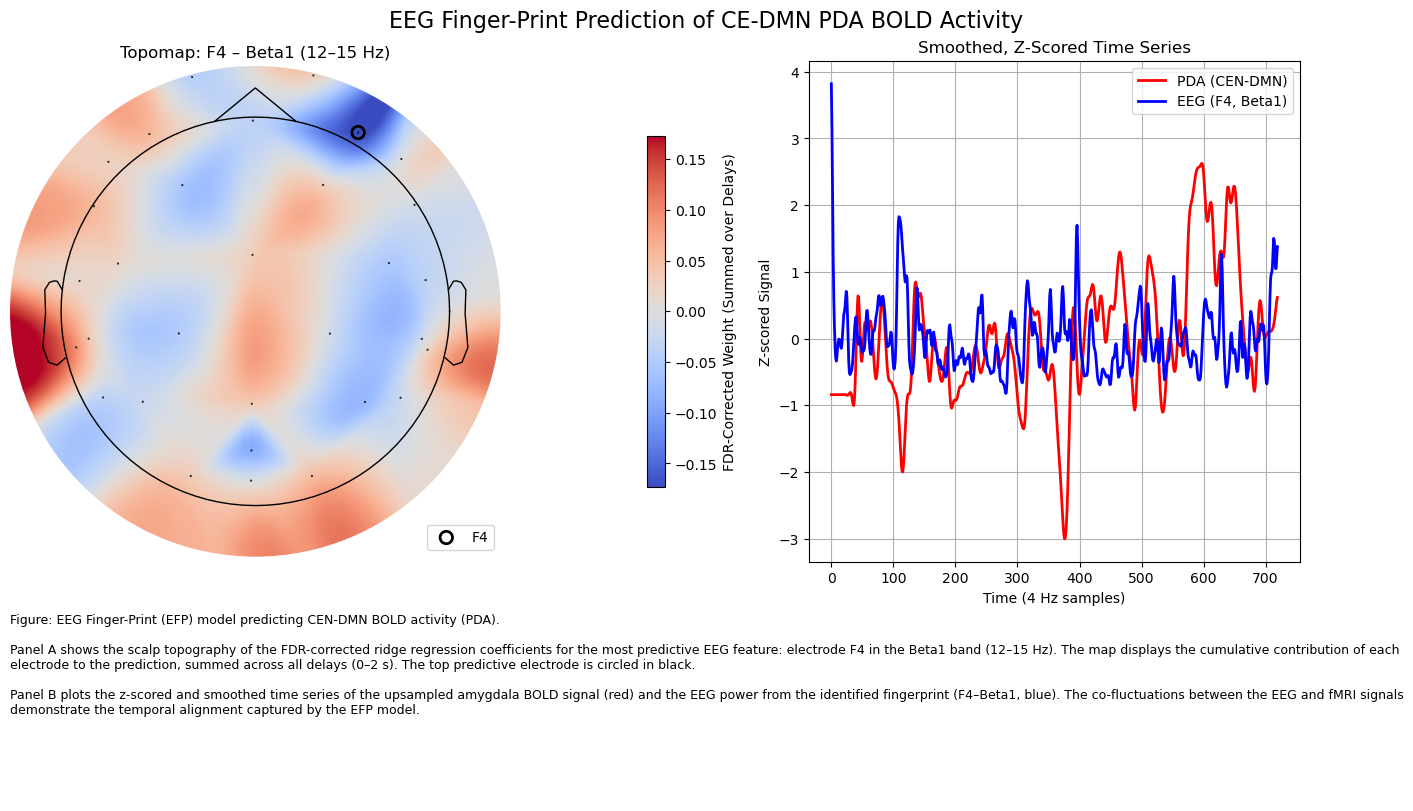

In [82]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mne.viz import plot_topomap
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore

# Define frequency ranges
band_ranges_hz = {
    "Delta": (1, 4),
    "Theta": (4, 7),
    "Alpha1": (7, 9),
    "Alpha2": (9, 12),
    "Beta1": (12, 15),
    "Beta2": (15, 20),
    "Beta3": (20, 25),
    "Beta4": (25, 30),
    "Gamma1": (30, 35),
    "Gamma2": (35, 40)
}

# Figure layout: 2 rows (topo + timeseries, caption)
fig = plt.figure(figsize=(14, 8), constrained_layout=True)
gs = GridSpec(2, 2, figure=fig, height_ratios=[2, 0.75])

# Panel A: Topomap
ax1 = fig.add_subplot(gs[0, 0])
im, _ = plot_topomap(valid_weights, valid_pos, axes=ax1, cmap="coolwarm", contours=0, show=False)
ax1.scatter(*top_plot_pos, color='black', s=80, facecolors='none', linewidths=2, label=f'{top_ch_name}')
f_range = band_ranges_hz.get(top_band_name, ("?", "?"))
cbar = plt.colorbar(im, ax=ax1, shrink=0.7, label='FDR-Corrected Weight (Summed over Delays)')
ax1.set_title(f"Topomap: {top_ch_name} ‚Äì {top_band_name} ({f_range[0]}‚Äì{f_range[1]} Hz)")
ax1.legend(loc="lower right")

# Panel B: Time Series
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(pda_smooth, label='PDA (CEN-DMN)', color='red', linewidth=2)
ax2.plot(eeg_smooth, label=f'EEG ({top_ch_name}, {top_band_name})', color='blue', linewidth=2)
ax2.set_title("Smoothed, Z-Scored Time Series")
ax2.set_xlabel("Time (4 Hz samples)")
ax2.set_ylabel("Z-scored Signal")
ax2.legend()
ax2.grid(True)

# Panel C: Caption
caption = (
    f"Figure: EEG Finger-Print (EFP) model predicting CEN-DMN BOLD activity (PDA).\n\n"
    f"Panel A shows the scalp topography of the FDR-corrected ridge regression coefficients for the most predictive EEG feature: "
    f"electrode {top_ch_name} in the {top_band_name} band ({f_range[0]}‚Äì{f_range[1]} Hz). The map displays the cumulative contribution "
    "of each electrode to the prediction, summed across all delays (0‚Äì2 s). The top predictive electrode is circled in black.\n\n"
    "Panel B plots the z-scored and smoothed time series of the upsampled amygdala BOLD signal (red) and the EEG power from the identified "
    f"fingerprint ({top_ch_name}‚Äì{top_band_name}, blue). The co-fluctuations between the EEG and fMRI signals demonstrate the temporal alignment "
    "captured by the EFP model."
)

ax_caption = fig.add_subplot(gs[1, :])
ax_caption.axis("off")
ax_caption.text(0, 1, caption, ha='left', va='top', wrap=True, fontsize=9)

# Super title and save
fig.suptitle("EEG Finger-Print Prediction of CE-DMN PDA BOLD Activity", fontsize=16)
plt.savefig("../figures/EFP_summary_plot_with_caption.png", dpi=300)
"../figures/EFP_summary_plot_with_caption.png"
